# **Anamoly Detection Using AutoEncoders**

## Imports

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Dense
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

## Getting data

In [ ]:
!rm -rf *
!wget https://timeseriesclassification.com/Downloads/ECG5000.zip
!unzip -o ECG5000.zip -d ECG5000/
!cat ECG5000/ECG5000_TRAIN.txt ECG5000/ECG5000_TEST.txt > ECG.txt
!rm -rf ECG5000 ECG5000.zip

--2022-07-26 04:08:22--  https://timeseriesclassification.com/Downloads/ECG5000.zip
Resolving timeseriesclassification.com (timeseriesclassification.com)... 109.123.71.232
Connecting to timeseriesclassification.com (timeseriesclassification.com)|109.123.71.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10614407 (10M) [application/zip]
Saving to: ‘ECG5000.zip’

ECG5000.zip         100%[===================>]  10.12M  7.88MB/s    in 1.3s    

2022-07-26 04:08:24 (7.88 MB/s) - ‘ECG5000.zip’ saved [10614407/10614407]

Archive:  ECG5000.zip
  inflating: ECG5000/ECG5000.txt     
  inflating: ECG5000/ECG5000_TEST.arff  
  inflating: ECG5000/ECG5000_TEST.txt  
  inflating: ECG5000/ECG5000_TRAIN.arff  
  inflating: ECG5000/ECG5000_TRAIN.txt  
  inflating: ECG5000/ECG5000_TEST.ts  
  inflating: ECG5000/ECG5000_TRAIN.ts  


## Reading Data

In [ ]:
df = pd.read_csv("ECG.txt",sep="  ",header=None,engine='python')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


## Scaling and Spliting data

In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit(df.values)
train_data,test_data = train_test_split(df.values,test_size=0.2)
train_data.shape

(4000, 141)

In [ ]:
train_data_scaled = scaled.transform(train_data)
test_data_scaled = scaled.transform(train_data)

## Seperating normal and Anamoly data

In [ ]:
n_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
a_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:,1:]
print(n_train_data.shape,a_train_data.shape)

(2332, 140) (1668, 140)


In [ ]:
n_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
a_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:,1:]
print(n_test_data.shape,a_test_data.shape)

(2332, 140) (1668, 140)


### Normal data

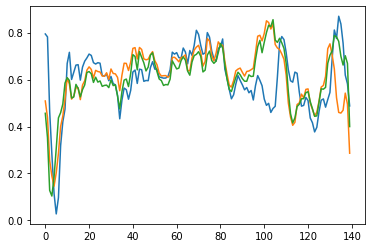

In [ ]:
plt.plot(n_train_data[0])
plt.plot(n_test_data[10])
plt.plot(n_train_data[50])

### Anamoly data

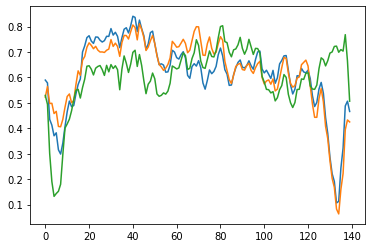

In [ ]:
plt.plot(a_test_data[0])
plt.plot(a_train_data[10])
plt.plot(a_test_data[50])

## Auto Encoder class

In [ ]:
class AutoEncoder(Model):
  def __init__(self):
      super(AutoEncoder,self).__init__()
      self.encoder = tf.keras.Sequential([
        Dense(128,activation = 'relu'),
        Dense(64,activation = 'relu'),
        Dense(32,activation = 'relu'),
        Dense(16,activation = 'relu')                        
      ])
      self.decoder = tf.keras.Sequential([
        Dense(16,activation = 'relu'),
        Dense(32,activation = 'relu'),
        Dense(64,activation = 'relu'),
        Dense(128,activation = 'relu'),
        Dense(140,activation = 'sigmoid')  
      ])
  def call(self,x):
      return self.decoder(self.encoder(x))

## Training Data

In [ ]:
model = AutoEncoder()
model.compile(optimizer='adam',loss='mae')
history = model.fit(n_train_data,n_train_data,epochs=50)

## Testing

In [ ]:
reconstructions = model.predict(n_test_data)
train_loss = tf.keras.losses.mae(reconstructions,n_test_data)

In [ ]:
encoder_out = model.encoder(n_test_data).numpy()
decoder_out = model.decoder(encoder_out).numpy()
print(encoder_out.shape,decoder_out.shape)
n_loss = tf.keras.losses.mae(decoder_out,n_test_data)

(2332, 16) (2332, 140)


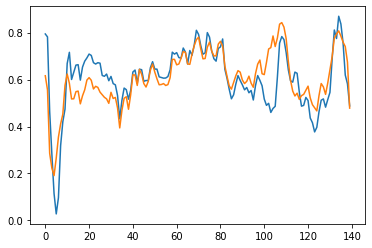

In [ ]:
plt.plot(n_test_data[0])
plt.plot(decoder_out[0])

In [ ]:
encoder_out = model.encoder(a_test_data).numpy()
decoder_out = model.decoder(encoder_out).numpy()
print(encoder_out.shape,decoder_out.shape)
a_loss = tf.keras.losses.mae(decoder_out,a_test_data)

(1668, 16) (1668, 140)


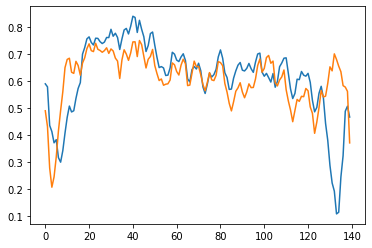

In [ ]:
plt.plot(a_test_data[0])
plt.plot(decoder_out[0])

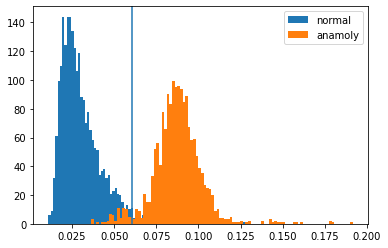

In [ ]:
plt.hist(n_loss,bins=100,label="normal")
plt.hist(a_loss,bins=100,label="anamoly")
threshold = np.mean(train_loss)+2*np.std(train_loss)
plt.axvline(threshold)
plt.legend(loc='upper right')

In [ ]:
data = scaled.transform(df.values) 
normal = data[:,0]==0
anamoly = data[:,0]>0
data = data[:,1:]
q = np.zeros(5000)
q[normal] = 0
q[anamoly] = 1

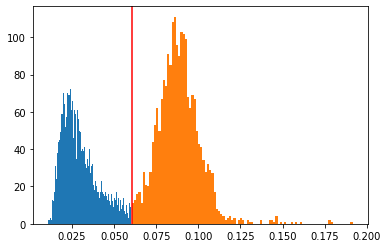

In [ ]:
reconstructions = model.predict(data)
loss = tf.keras.losses.mae(reconstructions,data)
normal =  loss<=threshold
anamoly = loss>threshold
p = np.zeros(5000)
p[normal] = 0
p[anamoly] = 1
plot = plt.hist(loss[normal],bins=100,label="normal")
plot = plt.hist(loss[anamoly],bins=100,label="anamoly")
plt.axvline(threshold,color='r')

In [ ]:
m1 = tf.keras.metrics.Accuracy()
m1.update_state(y_pred = p,y_true = q)
m1.result().numpy()*100

95.99999785423279

In [ ]:
tf.math.confusion_matrix(q,p).numpy()

array([[2803,  116],
       [  84, 1997]], dtype=int32)